# <b> Introduction </b>

These data come from a lab session done this semester in which students completed a baseline countermovement vertical jump (CMJ), <u> a 15-second Wingate test againts 7.5% of their body mass</u>, and then another CMJ. Goal of the lab was to introduce students to experimental designs by measuring something prior to and after (CMJ performance) some kind of intervention, in this case the intervention was the Wingate test. As well as introduce the energy systems associated with the Wingate test.
jlk 
For their lab reports, students were given discrete variables all calculated via the Hawkin force plates such as:
<ul>
    <li> <i> Jump height (cm) via impulse-momentum. </i>
    <li> <i> Modified reactive strength index [mRSI (AU)]. </i>
</ul>

For my own purposes of learning and improving my skills as a Python coder, I chose to use [the spm1d package](https://spm1d.org/index.html) for Statistical Parameteric Mapping (SPM) of the CMJ force time curves prior to (PRE) and after (POST) the Wingate. This is a package I have been wanting to experiment with for a while. Since in exercise and sports science, we spend so much time on discrete (peaks, means, etc.) variables but collect much more data than we actually analyze. SPM allows for the analysis of the entire force-time curve. 

In [22]:
# import packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tkinter.filedialog import askdirectory
import spm1d
from scipy.integrate import (cumulative_trapezoid as int_cumtrapz)

# defining plot theme. 
custom_theme = {"axes.spines.right": False, "axes.spines.top": False,
                "axes.titlelocation": "center", "axes.titley": 1,
                "font.weight":"bold", "axes.titlesize": "x-large", "axes.labelsize": "x-large",
                "axes.titleweight": "bold", "axes.labelweight": 'bold',
                'font.family': 'Tahoma'}

plt.rcParams.update({**custom_theme})


## <b> Data Loading </b>
Select the directory where the files are stored (clone the git repo if necessary). Print the file names and check the number of files that will be analyzed. 


In [4]:
dir_to_read = askdirectory(title = 'Select Directory to Read CMJ Files')
files_to_read = os.listdir(dir_to_read)

for file_to_print in files_to_read:
    print(file_to_print[:-4])
print(f'\nThere are {len(files_to_read)} files.')

001-POST
001-PRE
002-POST
002-PRE
003-POST
003-PRE
004-POST
004-PRE
005-POST
005-PRE
006-POST
006-PRE
007-POST
007-PRE
008-POST
008-PRE
009-POST
009-PRE

There are 18 files.


## <b> Custom Function for Analyzing CMJ Force Time Arrays </b>
Next, I'm writing a custom function to read the force arrays, identify the indices we need, crop the arrays to those indices, and then interpolate the data to 101 data points (0-100% of the CMJ phases of interest).</b>

Specifically, the CMJ force time data will be cropped from the point of movement initation ('start_move') to takeoff ('takeoff').

The index identification portion of the below code has been adapted from [Merrigan et al.](https://journals.lww.com/nsca-jscr/fulltext/2022/09000/analyzing_force_time_curves__comparison_of.4.aspx). 


In [70]:
# This is a custom function to read, analyze (find the indices of interest), crop, and interpolate the CMJ data
sf = 1000 # Hawkin sampling frequency = 1000 Hz

def read_files(file_path):
    full_data = pd.read_csv(file_path)
    
    # pull force array
    fz_total = full_data.iloc[:,0]
    
    return(fz_total)
    

def calculate_and_crop_and_interpolate_velo(fz_array):
    dat_len = len(fz_array)
    trial_time = dat_len / sf
    time_s = np.linspace(start = 0, stop = trial_time, num = dat_len)
        
    bw_mean = fz_array[0:1000].mean()
    bw_sd = fz_array[0:1000].std()
    bodymass = bw_mean/9.81
    
    # calculate arrays
    accel = (fz_array - bw_mean) / bodymass
    velo = int_cumtrapz(x = time_s, y = accel)
    position = int_cumtrapz(x = time_s[1:], y = velo)
    
    # crop arrays   
    start_move = 20
    
    while fz_array[start_move] > (bw_mean - (bw_sd * 5)):
        start_move = start_move + 1
        
    while fz_array[start_move] < (bw_mean - (bw_sd)):
        start_move = start_move - 1
    
    takeoff = start_move
    while fz_array[takeoff] > 30:
        takeoff = takeoff + 1
        
    # cropped velo
    cropped_velo = position[start_move:takeoff]
    
    max_position = position.max()
    max_pos_index = list(position).index(max_position)
    
    position = position[start_move:max_pos_index]
    cropped_velo = position
    # now interpolate velo
    original_data = np.linspace(0, len(cropped_velo)-1, len(cropped_velo))
    interpolated_indices = np.linspace(0, len(cropped_velo)-1, 101)
    interp_velo = np.interp(interpolated_indices, original_data, cropped_velo)
    
    return(interp_velo)


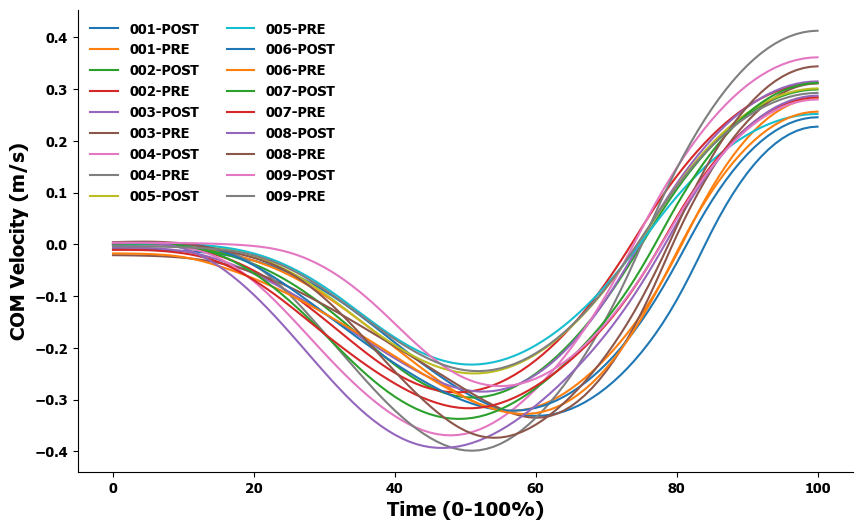

In [71]:
output_velo_data = pd.DataFrame()
plt.figure(figsize = (10, 6))
for file_to_read in files_to_read:
    full_name = os.path.join(dir_to_read, file_to_read)
    base_name = file_to_read[:-4]
    velo_to_read = read_files(full_name)
    cleaned_velo = calculate_and_crop_and_interpolate_velo(velo_to_read)
    
    output_velo_data[base_name] = cleaned_velo
   
    
    plt.plot(cleaned_velo, label = base_name)

plt.legend(loc = 'upper left', frameon = False, ncol = 2)
plt.xlabel('Time (0-100%)')
plt.ylabel('COM Velocity (m/s)');

# <b> Data Analysis </b>
<b> The next chunk will create the two arrays we will be analyzing in spm1d at - PRE vs. POST.</b>

<ol>
<li> First, filter the dataframes into post_df and pre_df based on column names
<li> Then transpose the dataframes into a J x Q matrix (subjects [rows] X nodes/points per trial [columns])
<li> Lastly, transfer the dataframe into an array for ease. 


In [72]:
pre_velo_df = output_velo_data.loc[:, output_velo_data.columns.str.contains('PRE')]
post_velo_df = output_velo_data.loc[:, output_velo_data.columns.str.contains('POST')]

pre_velo_transpose = pre_velo_df.T
post_velo_transpose = post_velo_df.T

pre_velo = np.array(pre_velo_transpose)
post_velo = np.array(post_velo_transpose)

## <b> Always Plot Your Data! </b>
The next code chunk will plot mean±SD values for PRE and POST prior to analysis. I will, similar to the plot above, overlay the individual responses as well.  
Very simply, calculate the mean for each data point (point 0, point 1, point 2, ... point 100).
Calculate the SD for each data point. 
Plot the mean data, plot the individual data, have the SD be as a shadow around the mean data. Label appropriately.  

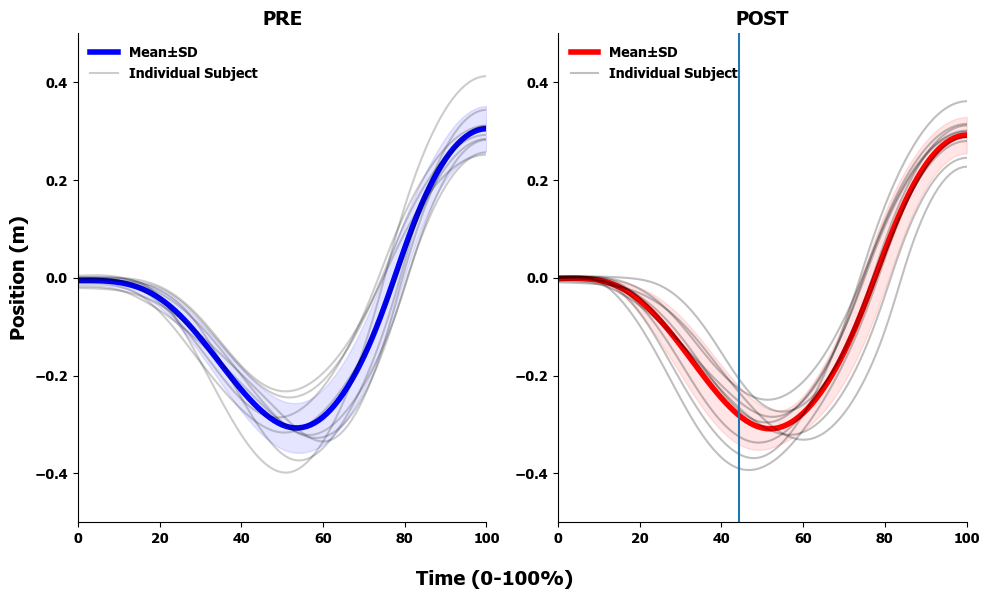

In [ ]:
# calcualte mean/sd for pre
pre_velo_mean = pre_velo.mean(axis = 0)
pre_velo_sd = pre_velo.std(axis = 0)

# calculate mean/sd for post
post_velo_mean = post_velo.mean(axis = 0)
post_velo_sd = post_velo.std(axis = 0)

# make an x values array for plotting purpsoes
x_vals = np.arange(101)

# initialize plot
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# on axis 0 = PRE
axes[0].plot(x_vals, pre_velo_mean, color='blue', linewidth=4, label = 'Mean±SD') 
# for loop to overlay the individaul responses 
for i, data_to_plot in enumerate(pre_velo):
    label = 'Individual Subject' if i == 0 else None 
    # brute force way to add 
    # a legend depicting what the lines mean, just assigning the label for only the first subject. 
    axes[0].plot(x_vals, data_to_plot, color = 'black', alpha = 0.2, label = label)
axes[0].fill_between(x_vals, pre_velo_mean - pre_velo_sd, pre_velo_mean + pre_velo_sd, color='blue', alpha=0.1)
axes[0].set_xlim(0, 100)
axes[0].set_ylim(-0.5, 0.5)
axes[0].set_ylabel('Position (m)')
axes[0].set_title('PRE')
axes[0].legend(frameon = False, loc = 'upper left')

# on axis 1 = POST
axes[1].plot(x_vals, post_velo_mean, color='red', linewidth=4, label = 'Mean±SD')
# for loop again
for i, data_to_plot in enumerate(post_velo):
    label = 'Individual Subject' if i == 0 else None
    axes[1].plot(x_vals, data_to_plot, color = 'black', alpha = 0.25, label = label)
axes[1].fill_between(x_vals, post_velo_mean - post_velo_sd, post_velo_mean + post_velo_sd, color='red', alpha=0.1)
axes[1].set_xlim(0, 100)
axes[1].set_ylim(-0.5, 0.5)
axes[1].set_title('POST')


axes[1].legend(frameon = False, loc = 'upper left')

# add a shared x-axis title
fig.supxlabel('Time (0-100%)', fontsize='x-large', fontweight='bold')

plt.tight_layout();

# <b> Running the SPM1D Analysis </b>
Now, this next code block will run the spm1d analyses. Since we have a within-subjects design, spm1d's paired t-test function will be used. 
The second block of this chunk will return the inferential test.

In [85]:
# assign the output to t and then view it
t = spm1d.stats.ttest_paired(pre_velo, post_velo)

# assign alpha
alpha = 0.05
ti = t.inference(alpha = alpha)
ti

SPM{t} inference field
   SPM.z         :  (1x101) raw test stat field
   SPM.df        :  (1, 8)
   SPM.fwhm      :  20.64545
   SPM.resels    :  (1, 4.84368)
Inference:
   SPM.alpha     :  0.050
   SPM.zstar     :  4.12785
   SPM.h0reject  :  False
   SPM.p_set     :  1.000
   SPM.p_cluster :  ()



<b> Plotting the SPM results. </b>

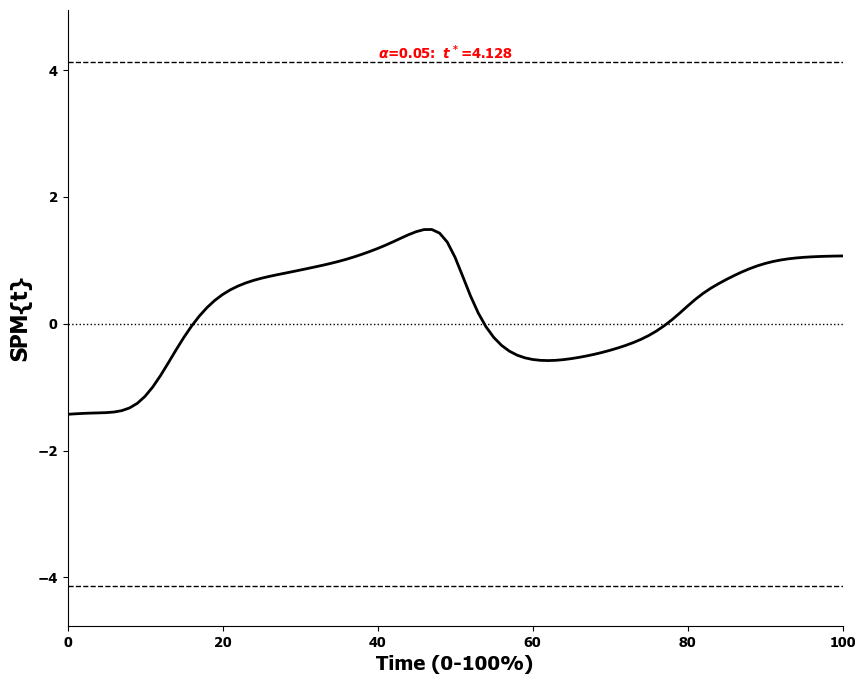

In [86]:
plt.figure(figsize = (10,8))
ti.plot()
ti.plot_threshold_label()
plt.xlabel('Time (0-100%)');

# <b> Conclusion </b>
From the results of the SPM analysis, there was no effect of the 15-second Wingate test on CMJ performance. Why? The population was solely student-athletes and 15-seconds of a Wingate may not have resulted in enough fatigue to interrupt their CMJ strategy. 